In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

Load data and preprocess

In [138]:
data = pd.read_csv('data/processed_data.csv', parse_dates=['DateTime'], index_col='DateTime')
data = data.resample('60T').mean()
data = data[(data['Temperature'] >= data['Temperature'].quantile(0.1)) & (data['Temperature'] <= data['Temperature'].quantile(0.9))]

In [139]:
data

,Year,Month,Date,Time,Minute,Temperature,Previous Day Average,Two Days Before Average,Three Days Before Average,Last 7 Days Average,Previous Day Wind Speed,Previous Day Rainfall
DateTime,,,,,,,,,,,,
2008-01-08 00:00:00,2008.0,1.0,8.0,0.0,1.000000,14.700000,16.037500,13.475000,11.404167,29.403571,18.708333,0.0
2008-01-08 03:00:00,2008.0,1.0,8.0,3.0,1.000000,14.900000,16.037500,13.475000,11.404167,29.403571,18.708333,0.0
2008-01-08 04:00:00,2008.0,1.0,8.0,4.0,1.000000,15.000000,16.037500,13.475000,11.404167,29.403571,18.708333,0.0
2008-01-08 05:00:00,2008.0,1.0,8.0,5.0,1.000000,15.000000,16.037500,13.475000,11.404167,29.403571,18.708333,0.0
2008-01-08 06:00:00,2008.0,1.0,8.0,6.0,1.000000,15.500000,16.037500,13.475000,11.404167,29.403571,18.708333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-29 08:00:00,2023.0,6.0,29.0,8.0,27.500000,21.825000,21.965333,22.232558,22.367816,22.245981,NaN,NaN
2023-06-29 09:00:00,2023.0,6.0,29.0,9.0,23.333333,22.066667,21.965333,22.232558,22.367816,22.245981,NaN,NaN
2023-06-29 20:00:00,2023.0,6.0,29.0,2.0,0.000000,21.600000,21.965333,22.232558,22.367816,22.245981,NaN,NaN


Prepare dataset

In [140]:
def create_dataset(series, look_back=1):
    X, Y = [], []
    for i in range(len(series)-look_back-1):
        X.append(series[i:(i+look_back), 0])
        Y.append(series[i + look_back, 0])
    return np.array(X), np.array(Y)

In [141]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data['Temperature'].values.reshape(-1, 1))

In [142]:
train_size = int(len(dataset) * 0.8)
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [143]:
look_back = 12
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [144]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

Create and train LSTM model

In [145]:
model = Sequential([
    LSTM(50, input_shape=(1, look_back)),
    Dense(32),
    Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')

2023-06-29 18:14:44.403059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 18:14:44.404988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 18:14:44.406631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [146]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = LearningRateScheduler(lambda epoch: 0.001 * 0.9 ** epoch)

In [147]:
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping, lr_scheduler])

Epoch 1/100


2023-06-29 18:14:44.619585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 18:14:44.620671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 18:14:44.621608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2228/2248 [============================>.] - ETA: 0s - loss: 0.0052

2023-06-29 18:14:49.610825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 18:14:49.612503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 18:14:49.613593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2248/2248 [==============================] - 5s 2ms/step - loss: 0.0051 - val_loss: 0.0034 - lr: 0.0010
Epoch 2/100
2248/2248 [==============================] - 4s 2ms/step - loss: 0.0030 - val_loss: 0.0032 - lr: 9.0000e-04
Epoch 3/100
2248/2248 [==============================] - 4s 2ms/step - loss: 0.0030 - val_loss: 0.0032 - lr: 8.1000e-04
Epoch 4/100
2248/2248 [==============================] - 4s 2ms/step - loss: 0.0030 - val_loss: 0.0033 - lr: 7.2900e-04
Epoch 5/100
2248/2248 [==============================] - 4s 2ms/step - loss: 0.0029 - val_loss: 0.0031 - lr: 6.5610e-04
Epoch 6/100
2248/2248 [==============================] - 3s 2ms/step - loss: 0.0029 - val_loss: 0.0031 - lr: 5.9049e-04
Epoch 7/100
2248/2248 [==============================] - 4s 2ms/step - loss: 0.0029 - val_loss: 0.0032 - lr: 5.3144e-04
Epoch 8/100
2248/2248 [==============================] - 3s 2ms/step - loss: 0.0029 - val_loss: 0.0033 - lr: 4.7830e-04
Epoch 9/100
2248/2248 [==============================] -

Predictions and metrics

In [148]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

  61/2498 [..............................] - ETA: 2s   

2023-06-29 18:18:35.706443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 18:18:35.707656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 18:18:35.708494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

625/625 [==============================] - 1s 1ms/step


In [149]:
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])[0]
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])[0]

In [150]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train, train_predict[:,0]))
print('Train Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_train, train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict[:,0]))
print('Test Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_test, test_predict[:,0])))

Train Mean Absolute Error: 0.46494425478479734
Train Root Mean Squared Error: 0.684655506014431
Test Mean Absolute Error: 0.4827439462555455
Test Root Mean Squared Error: 0.7238474163456854


Plot training and test predictions

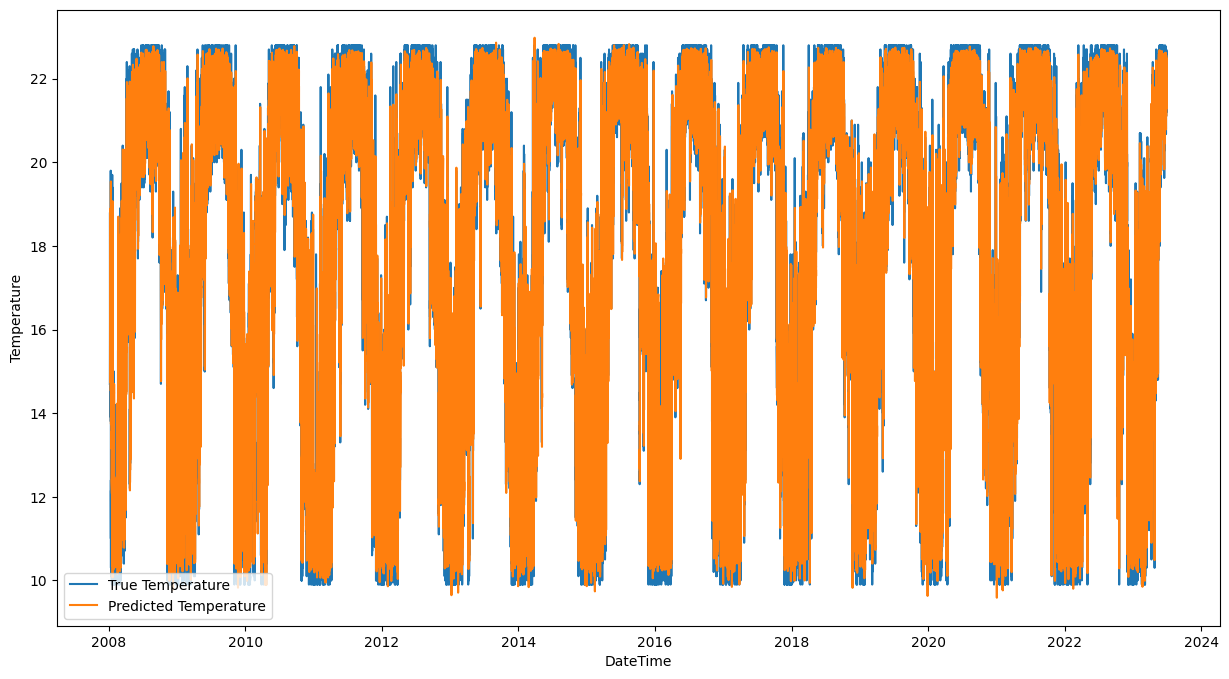

In [151]:
plt.figure(figsize=(15, 8))
plt.plot(data['Temperature'], label='True Temperature')
plt.plot(pd.Series(np.concatenate([train_predict[:, 0], test_predict[:, 0]]), index=data.index[look_back*2+2:]), label='Predicted Temperature')
plt.xlabel("DateTime")
plt.ylabel("Temperature")
plt.legend()
plt.show()

Plot the loss curves

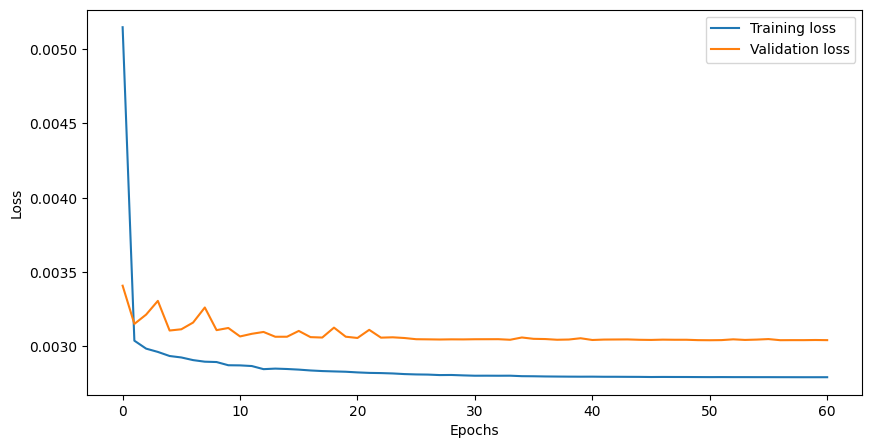

In [152]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Predict next 24 hours

In [163]:
last_24_hours = dataset[-look_back:]
last_24_hours = np.reshape(last_24_hours, (1, 1, look_back))
next_24_hours = []

In [164]:
for _ in range(72):
    prediction = model.predict(last_24_hours)
    next_24_hours.append(prediction[0][0])
    last_24_hours = np.append(last_24_hours[:, :, 1:], prediction)
    last_24_hours = np.reshape(last_24_hours, (1, 1, look_back))

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 13ms/step


In [165]:
next_24_hours = scaler.inverse_transform(np.array(next_24_hours).reshape(-1, 1))

In [166]:
print("Predicted temperatures for next 24 hours:")
print(next_24_hours)

Predicted temperatures for next 24 hours:
[[21.632477]
 [21.613478]
 [21.559353]
 [21.566748]
 [21.558294]
 [21.545155]
 [21.600712]
 [21.579084]
 [21.62787 ]
 [21.618963]
 [21.619959]
 [21.624626]
 [21.617096]
 [21.614346]
 [21.606153]
 [21.596743]
 [21.595415]
 [21.584461]
 [21.58717 ]
 [21.582571]
 [21.584288]
 [21.585234]
 [21.585379]
 [21.586649]
 [21.58681 ]
 [21.586443]
 [21.586428]
 [21.584423]
 [21.583897]
 [21.58163 ]
 [21.580467]
 [21.57892 ]
 [21.577686]
 [21.576801]
 [21.575994]
 [21.575378]
 [21.574982]
 [21.574434]
 [21.57417 ]
 [21.573612]
 [21.573221]
 [21.57265 ]
 [21.572096]
 [21.57151 ]
 [21.570904]
 [21.570318]
 [21.569767]
 [21.569225]
 [21.568762]
 [21.568296]
 [21.567898]
 [21.567503]
 [21.567142]
 [21.566788]
 [21.566442]
 [21.566103]
 [21.56577 ]
 [21.565435]
 [21.565115]
 [21.56479 ]
 [21.564482]
 [21.56418 ]
 [21.563898]
 [21.563622]
 [21.563356]
 [21.563108]
 [21.562866]
 [21.562634]
 [21.56241 ]
 [21.562193]
 [21.561983]
 [21.561779]]


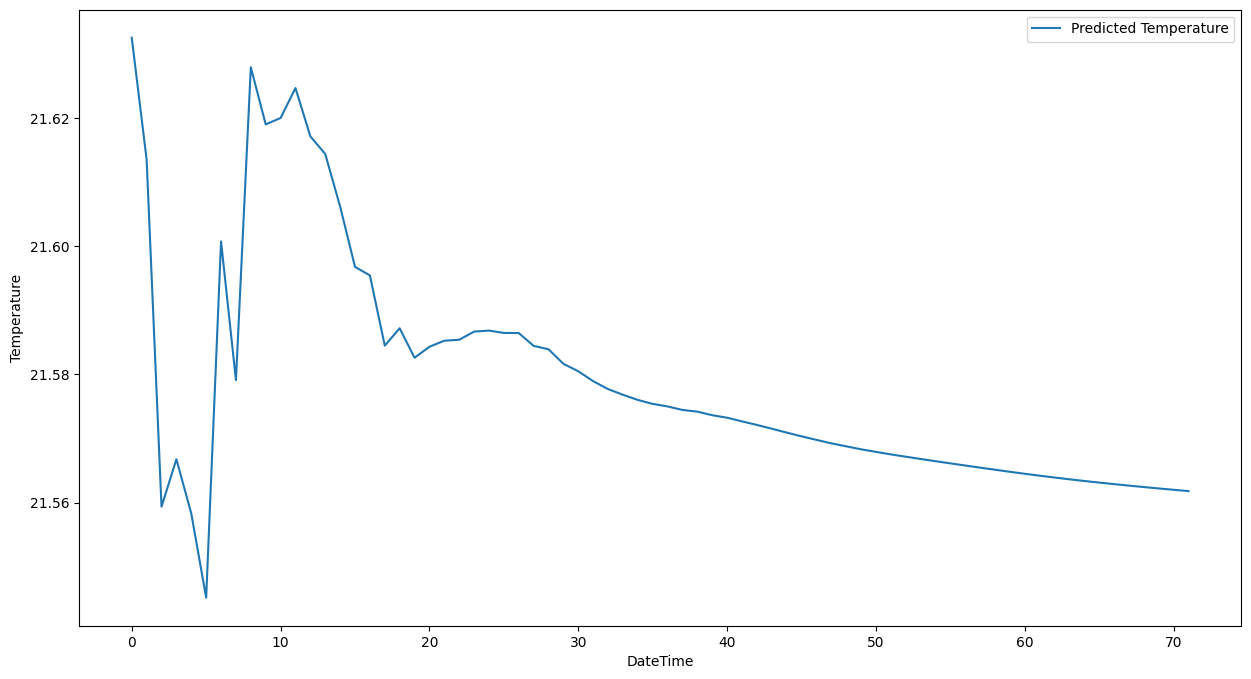

In [168]:
plt.figure(figsize=(15, 8))
plt.plot(pd.Series(next_24_hours.flatten(), index=range(72)), label='Predicted Temperature')
plt.xlabel("DateTime")
plt.ylabel("Temperature")
plt.legend()
plt.show()

In [158]:
model.save("lstm_new.keras")